In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-dataset/LoanDataset - LoansDatasest.csv


Rows, columns: (32586, 13)
Columns found: ['customer_id', 'customer_age', 'customer_income', 'home_ownership', 'employment_duration', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'term_years', 'historical_default', 'cred_hist_length', 'current_loan_status']

Target distribution:
target_default
0.0    25742
1.0     6840
Name: count, dtype: int64

Missing values:
customer_id                3
customer_age               0
customer_income            4
home_ownership             0
employment_duration      895
loan_intent                0
loan_grade                 0
loan_amnt              32586
loan_int_rate           3116
term_years                 0
historical_default     20737
cred_hist_length           0
current_loan_status        4
target_default             4
hist_default_flag      20737
dtype: int64

Overall Default Rate:
20.99%

Default rate by Loan Intent:
loan_intent
DEBTCONSOLIDATION    0.303856
MEDICAL              0.250823
HOMEIMPROVEMENT      0.244592
PERSONAL    

/tmp/ipykernel_47/4106407032.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_rate = df.groupby("income_bucket")["target_default"].mean()
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


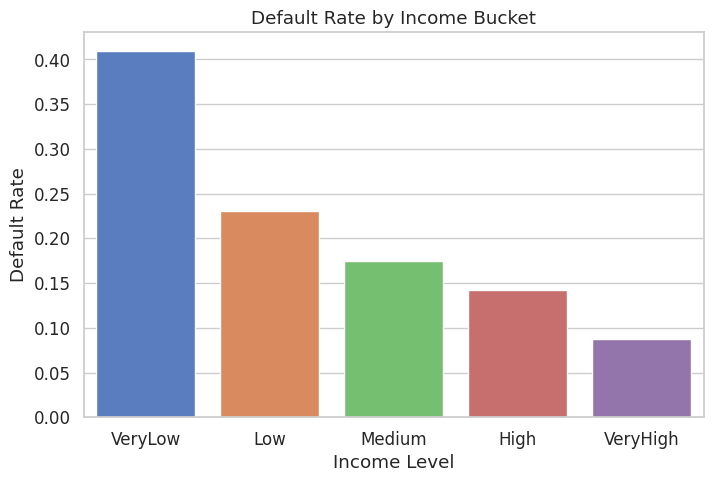

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


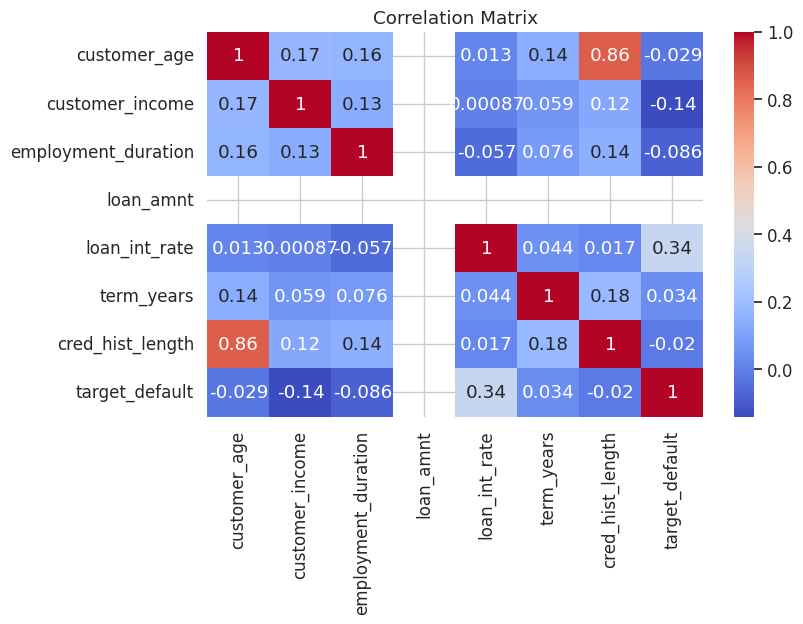


Logistic Regression
Accuracy: 0.9355531686358755
Precision: 0.9030612244897959
Recall: 0.7763157894736842
F1: 0.8349056603773585
ROC AUC: 0.962274653909974
Confusion Matrix:
 [[5035  114]
 [ 306 1062]]
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      5149
         1.0       0.90      0.78      0.83      1368

    accuracy                           0.94      6517
   macro avg       0.92      0.88      0.90      6517
weighted avg       0.93      0.94      0.93      6517


Random Forest
Accuracy: 0.9625594598741752
Precision: 0.9660033167495854
Recall: 0.8516081871345029
F1: 0.9052059052059053
ROC AUC: 0.9847329550165308
Confusion Matrix:
 [[5108   41]
 [ 203 1165]]
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      5149
         1.0       0.97      0.85      0.91      1368

    accuracy                           0.96      6517
   macro avg       0.96      0.92      0.94      6517


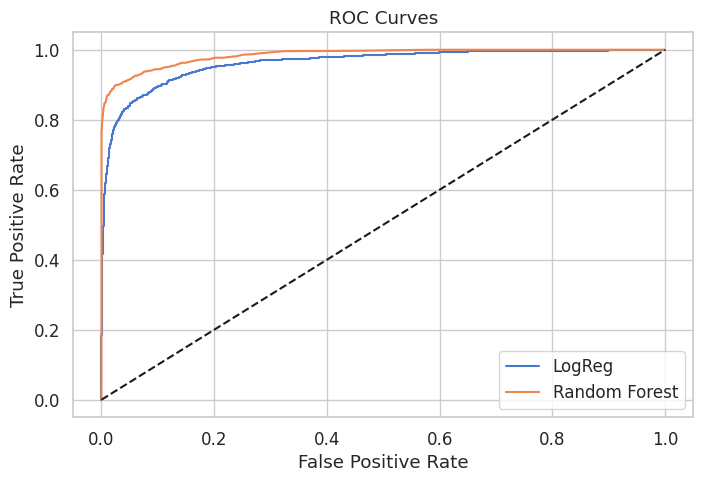


Permutation Importances (Top 15):
hist_default_flag      0.201527
loan_grade             0.107359
loan_intent            0.056931
home_ownership         0.039275
customer_income        0.035028
cred_hist_length       0.031571
customer_age           0.027742
loan_int_rate          0.026300
employment_duration    0.025528
term_years             0.015619
loan_amnt              0.000000
dtype: float64


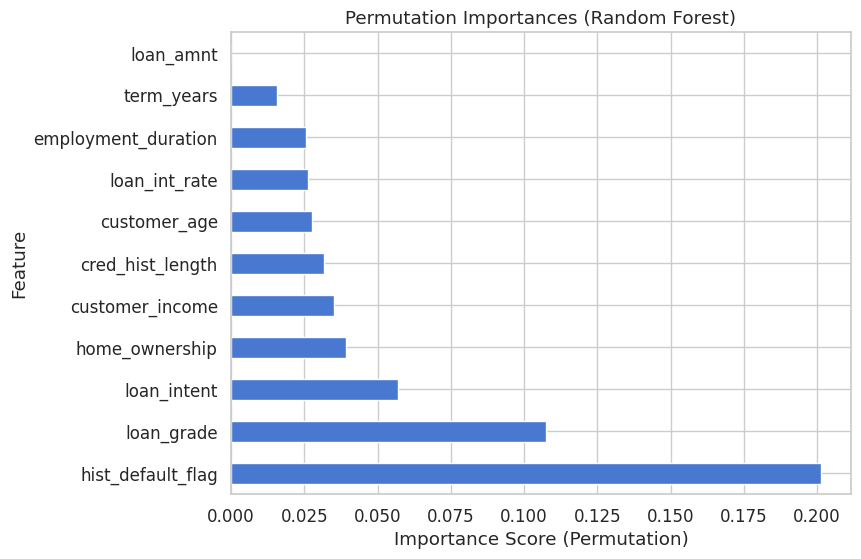

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)

sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8,5)

DATA_PATH = "/kaggle/input/loan-dataset/LoanDataset - LoansDatasest.csv"

df = pd.read_csv(DATA_PATH)

print("Rows, columns:", df.shape)
df.head()

# ------------------------------------------------------------
# 2. BASIC CLEANING + TARGET PREP
# ------------------------------------------------------------

# Standardize column names (common for Kaggle datasets)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Expecting the following:
# customer_id, customer_age, customer_income, home_ownership,
# employment_duration, loan_intent, loan_grade, loan_amnt,
# loan_int_rate, term_years, historical_default,
# cred_hist_length, current_loan_status

print("Columns found:", df.columns.tolist())

# Create binary target: DEFAULT = 1 / NO DEFAULT = 0
df["current_loan_status"] = df["current_loan_status"].str.upper().str.replace(" ", "")
df["target_default"] = df["current_loan_status"].map({
    "DEFAULT": 1,
    "NODEFAULT": 0,
    "NODEFAULT": 0,
    "NO_DEFAULT": 0
})

print("\nTarget distribution:")
print(df["target_default"].value_counts())

# Historical default flag Y/N
df["hist_default_flag"] = df["historical_default"].astype(str).str.upper().map({
    "Y": 1,
    "N": 0
})

# Convert numeric columns
num_cols = [
    "customer_age","customer_income","employment_duration",
    "loan_amnt","loan_int_rate","term_years","cred_hist_length"
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print("\nMissing values:")
print(df.isnull().sum())

# ------------------------------------------------------------
# 3. EXPLORATORY DATA ANALYSIS
# ------------------------------------------------------------

print("\nOverall Default Rate:")
default_rate = df["target_default"].mean()
print(f"{default_rate:.2%}")

# Default rate by loan intent
if "loan_intent" in df.columns:
    intent_table = df.groupby("loan_intent")["target_default"].mean().sort_values(ascending=False)
    print("\nDefault rate by Loan Intent:")
    print(intent_table)

# Default rate by loan grade
if "loan_grade" in df.columns:
    grade_table = df.groupby("loan_grade")["target_default"].mean().sort_values(ascending=False)
    print("\nDefault rate by Loan Grade:")
    print(grade_table)

# Income buckets
df["income_bucket"] = pd.qcut(
    df["customer_income"].fillna(0) + 1,
    q=5,
    labels=["VeryLow","Low","Medium","High","VeryHigh"]
)

income_rate = df.groupby("income_bucket")["target_default"].mean()
print("\nDefault rate by Income Bucket:")
print(income_rate)

# Visualization – Default by income bucket
sns.barplot(x=income_rate.index, y=income_rate.values)
plt.title("Default Rate by Income Bucket")
plt.ylabel("Default Rate")
plt.xlabel("Income Level")
plt.show()

# Correlation heatmap
corr = df[num_cols + ["target_default"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


# ------------------------------------------------------------
# 4. MODELING — Logistic Regression & Random Forest
# ------------------------------------------------------------

# Select features
categorical_features = ["home_ownership","loan_intent","loan_grade"]
numeric_features = num_cols + ["hist_default_flag"]

features = numeric_features + categorical_features

df_model = df[features + ["target_default"]].dropna(subset=["target_default"])

X = df_model[features]
y = df_model["target_default"]

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Logistic Regression
logreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

# Random Forest
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train models
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predictions
y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:,1]

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

# ------------------------------------------------------------
# 5. MODEL EVALUATION
# ------------------------------------------------------------
def print_eval(name, y_true, y_pred, y_prob):
    print("\n==============================")
    print(name)
    print("==============================")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1:", f1_score(y_true, y_pred, zero_division=0))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, zero_division=0))

print_eval("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
print_eval("Random Forest", y_test, y_pred_rf, y_prob_rf)

# ROC Curve Comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 6. FEATURE IMPORTANCE (Random Forest) 
# ------------------------------------------------------------
from sklearn.inspection import permutation_importance

# Compute permutation importances
perm = permutation_importance(
    rf,
    X_train,
    y_train,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Use original (pre-encoded) column names
base_feature_names = list(X_train.columns)

perm_importances = pd.Series(perm.importances_mean, index=base_feature_names)

print("\nPermutation Importances (Top 15):")
print(perm_importances.sort_values(ascending=False).head(15))

perm_importances.sort_values(ascending=False).head(15).plot(kind="barh", figsize=(8,6))
plt.title("Permutation Importances (Random Forest)")
plt.xlabel("Importance Score (Permutation)")
plt.ylabel("Feature")
plt.show()